In [1]:
# Import the appropriate libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

# This can be removed after the first run
#%pip install scipy


Note: you may need to restart the kernel to use updated packages.


Objective
The goal is to investigate whether or not there is a "home field advantage" for a nation that hosts the Olympic games. This analysis will study the Brazil olympic team, and try to determine if there was an unusually high improvement in performance during the 2016 Summer Olympic Games in Rio de Janeiro.

Metrics to Produce
We will look at the following metrics in order to check for a host advantage, considering medal count as the measure for success in an Olympic Games:

Medal count trends:
Did the total medal count increase during the hosted olympics?
How many standard deviations (z-score) from the average medal count across all olympic games was the medal count for the hosted games?
Where did the host country place on the total medal rankings in their hosted games vs. other games?
How did the host country's performance metrics compare to the rest of the world's metrics? Does that tell us anything?

In [2]:
# Read CSV file into a dataframe
olympics_path = "resources/athlete_events.csv"

olympics_df = pd.read_csv(olympics_path, low_memory = False)

# View the first 5 rows
olympics_df.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [3]:
# Use only the Summer Olympics for Analysis
summer_df = olympics_df[olympics_df['Season'] == 'Summer']


In [4]:
# Create variables for the specific host country
host_country = 'Brazil'
host_NOC = 'BRA'
host_year = 2016
host_city = 'Rio de Janeiro'

# Create a dataframe for only the host country, where the host value is anywhere in the team name
host_df = summer_df[summer_df['Team'].str.contains(host_country, case=False)]

# Print the unique values of various host columns to see if they are all related to the host country we are looking for
print(host_df['Team'].unique())
print(host_df['NOC'].unique())
print(host_df['City'].unique())

# Clean up the Team column to have ensure a single value for host
host_df.loc[:, 'Team'] = host_country
print(host_df['Team'].unique())

# It looks like NOC is a more accurate way to describe the country's team,
# and doesn't pose as many issues as the Team column does (e.g. "China-1", "China-2", etc.)
# Let's use NOC instead of Team for the rest of the analysis.

['Brazil' 'Brazil-1' 'Brazil-2']
['BRA']
['Munich' 'Montreal' 'Rio de Janeiro' 'Athina' 'Los Angeles' 'Seoul'
 'London' 'Helsinki' 'Tokyo' 'Moskva' 'Barcelona' 'Atlanta' 'Sydney'
 'Beijing' 'Berlin' 'Mexico City' 'Melbourne' 'Roma' 'Antwerpen' 'Paris'
 'Stockholm']
['Brazil']


In [5]:
# Create a dataframe where NOC is not related to the host country
rest_of_world_df = summer_df[summer_df['NOC'] != host_NOC]

# Clean up the team names to have only the country name
# if "-" appears in the team name, use only the part of the string that comes before "-"
rest_of_world_df.loc[:, 'Team'] = rest_of_world_df['Team'].str.split('-').str[0]

In [6]:
# Create a dataframe that is the rest_of_world_df (referred to now as rw) grouped by Games, then NOC
# We can use this to calculate medal counts for each country in each Games
games_df_rw = rest_of_world_df.groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
# This will be, for each NOC, the sum of the medals won in each category for each games
games_df_rw['gold_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Gold'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['silver_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Silver'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['bronze_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Bronze'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']

# Create a clean column for total medals
games_df_rw['total_medals'] = games_df_rw['Medal'] + games_df_rw['gold_medals'] + games_df_rw['silver_medals'] + games_df_rw['bronze_medals']

# Fill NaN values with 0
games_df_rw = games_df_rw.fillna(0)

# Format values in all columns except Games to integers
games_df_rw = games_df_rw.astype({'Medal': 'int', 'gold_medals': 'int', 'silver_medals': 'int', 'bronze_medals': 'int'})

# View the dataframe

games_df_rw

,Games,NOC,Medal,gold_medals,silver_medals,bronze_medals,total_medals
0,1896 Summer,AUS,3,2,1,1,7.0
1,1896 Summer,AUT,5,2,2,2,11.0
2,1896 Summer,DEN,6,1,4,3,14.0
3,1896 Summer,FRA,11,5,3,2,21.0
4,1896 Summer,GBR,9,3,5,3,20.0
...,...,...,...,...,...,...,...
2782,2016 Summer,VIE,2,0,0,0,0.0
2783,2016 Summer,VIN,0,0,0,0,0.0
2784,2016 Summer,YEM,0,0,0,0,0.0
2785,2016 Summer,ZAM,0,0,0,0,0.0


In [7]:
# Create a dataframe for the host country in the Summer Olympics grouped by Games.
games_df_host = host_df.groupby('Games').agg({'Medal': 'count'})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_host['gold_medals'] = host_df[host_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_host['silver_medals'] = host_df[host_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_host['bronze_medals'] = host_df[host_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# Fill NaN values with 0
games_df_host = games_df_host.fillna(0)

# Format values in all columns except Games to integers
games_df_host = games_df_host.astype(int)

# View the dataframe
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals
Games,,,,
1900 Summer,0,0,0,0
1920 Summer,7,1,1,5
1924 Summer,0,0,0,0
1932 Summer,0,0,0,0
1936 Summer,0,0,0,0
1948 Summer,10,0,0,10
1952 Summer,3,1,0,2
1956 Summer,1,1,0,0
1960 Summer,13,0,0,13


In [8]:
# Create a cleaner "total_medals" column
games_df_host['total_medals'] = games_df_host[['gold_medals', 'silver_medals', 'bronze_medals']].sum(axis=1)

# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_host['non_medal_participations'] = host_df[host_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_host['total_participations'] = host_df.groupby('Games').size()
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations
Games,,,,,,,
1900 Summer,0,0,0,0,0,3,3
1920 Summer,7,1,1,5,7,31,38
1924 Summer,0,0,0,0,0,18,18
1932 Summer,0,0,0,0,0,67,67
1936 Summer,0,0,0,0,0,93,93
1948 Summer,10,0,0,10,10,91,101
1952 Summer,3,1,0,2,3,111,114
1956 Summer,1,1,0,0,1,60,61
1960 Summer,13,0,0,13,13,69,82


In [9]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_host['medal_rate'] = games_df_host['total_medals'] / games_df_host['total_participations']
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate
Games,,,,,,,,
1900 Summer,0,0,0,0,0,3,3,0.000000
1920 Summer,7,1,1,5,7,31,38,0.184211
1924 Summer,0,0,0,0,0,18,18,0.000000
1932 Summer,0,0,0,0,0,67,67,0.000000
1936 Summer,0,0,0,0,0,93,93,0.000000
1948 Summer,10,0,0,10,10,91,101,0.099010
1952 Summer,3,1,0,2,3,111,114,0.026316
1956 Summer,1,1,0,0,1,60,61,0.016393
1960 Summer,13,0,0,13,13,69,82,0.158537


In [10]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_host['gold_percentage'] = games_df_host['gold_medals'] / games_df_host['total_medals']*100
games_df_host['silver_percentage'] = games_df_host['silver_medals'] / games_df_host['total_medals']*100
games_df_host['bronze_percentage'] = games_df_host['bronze_medals'] / games_df_host['total_medals']*100
games_df_host['non_medal_percentage'] = games_df_host['non_medal_participations'] / games_df_host['total_participations']*100

games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1900 Summer,0,0,0,0,0,3,3,0.000000,NaN,NaN,NaN,100.000000
1920 Summer,7,1,1,5,7,31,38,0.184211,14.285714,14.285714,71.428571,81.578947
1924 Summer,0,0,0,0,0,18,18,0.000000,NaN,NaN,NaN,100.000000
1932 Summer,0,0,0,0,0,67,67,0.000000,NaN,NaN,NaN,100.000000
1936 Summer,0,0,0,0,0,93,93,0.000000,NaN,NaN,NaN,100.000000
1948 Summer,10,0,0,10,10,91,101,0.099010,0.000000,0.000000,100.000000,90.099010
1952 Summer,3,1,0,2,3,111,114,0.026316,33.333333,0.000000,66.666667,97.368421
1956 Summer,1,1,0,0,1,60,61,0.016393,100.000000,0.000000,0.000000,98.360656
1960 Summer,13,0,0,13,13,69,82,0.158537,0.000000,0.000000,100.000000,84.146341


<Axes: title={'center': 'Medals Won by Brazil in the Summer Olympics'}, xlabel='Games'>

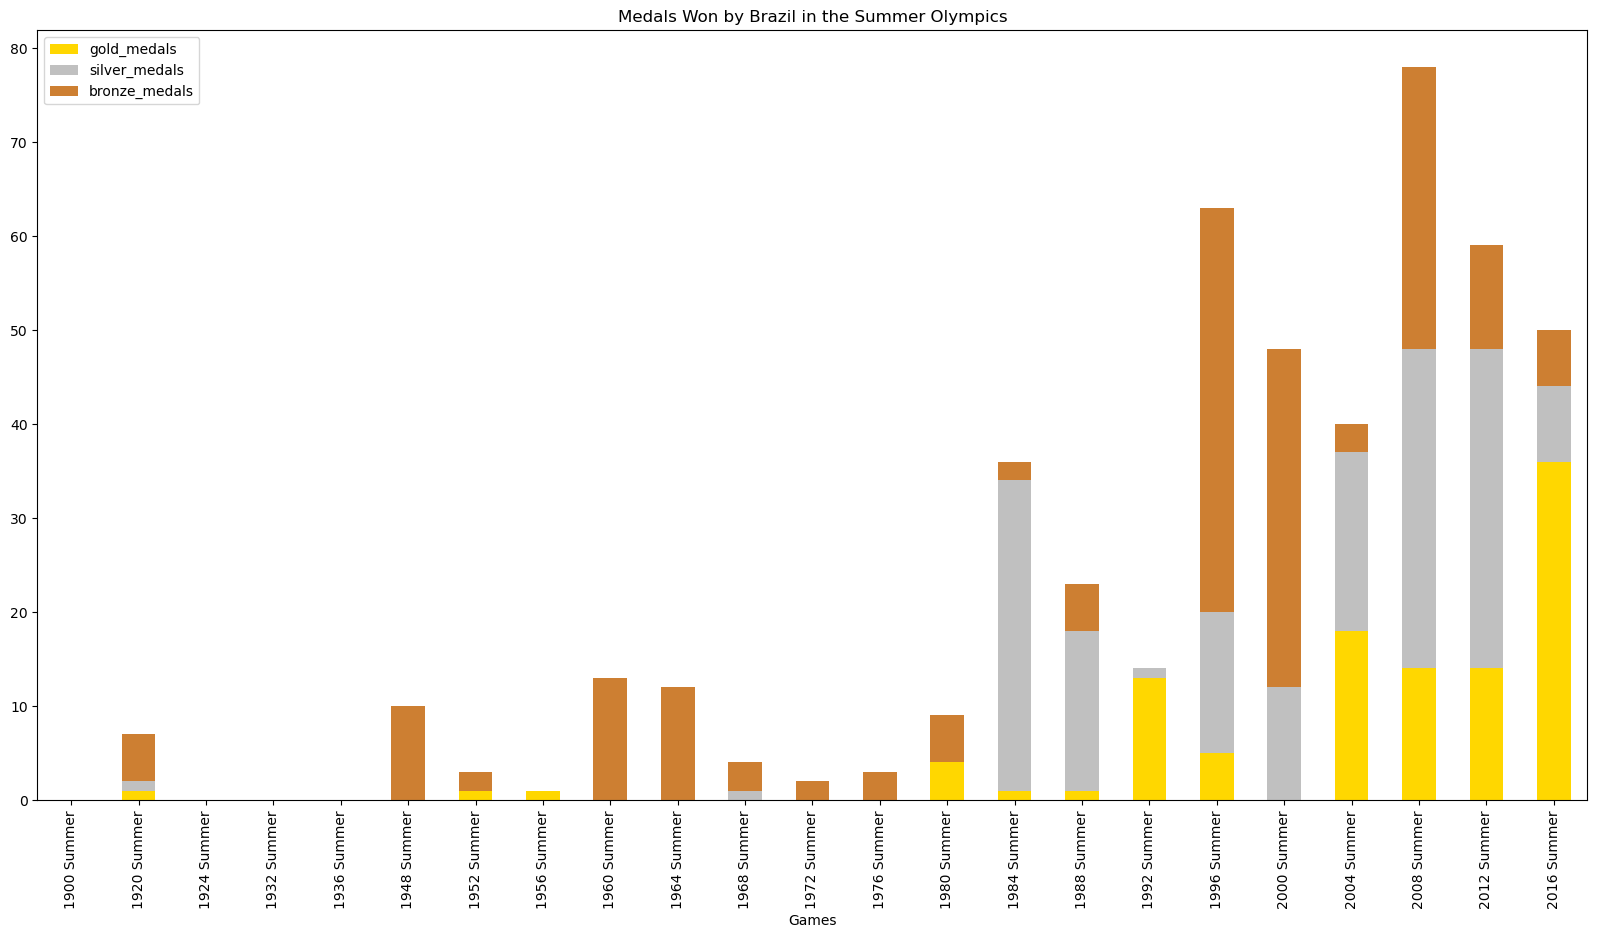

In [11]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the host country in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations

games_df_host[['gold_medals', 'silver_medals', 'bronze_medals']].plot(
                                    kind='bar',
                                    stacked=True,
                                    figsize=(20, 10),
                                    color=['#ffd700', '#c0c0c0', '#cd7f32'],
                                    title='Medals Won by Brazil in the Summer Olympics',)

# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze

c:\Users\17049\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\17049\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Axes: title={'center': 'Medals Won by Brazil in the Summer Olympics'}, xlabel='Games'>,
 Text(0.5, 1.0, 'Medals Won by Brazil in the Summer Olympics'))

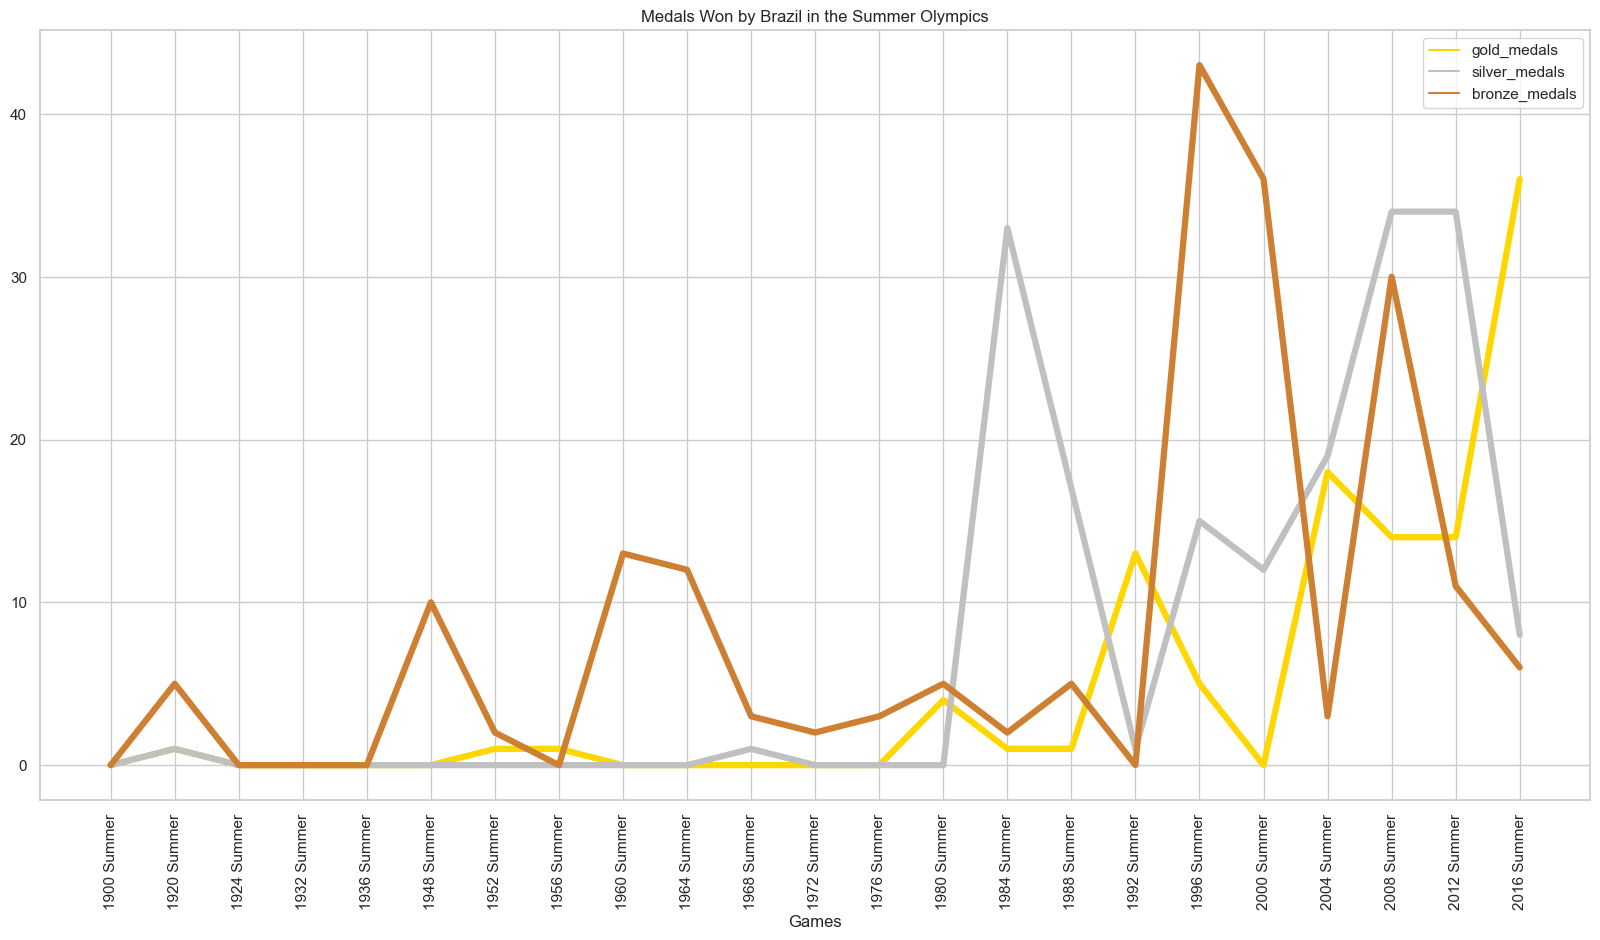

In [12]:
# Create a different visualization for the same data
sns.set_theme(style="whitegrid")

# Use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
data = games_df_host[['gold_medals', 'silver_medals', 'bronze_medals']]
palette = {'gold_medals': '#ffd700', 'silver_medals': '#c0c0c0', 'bronze_medals': '#cd7f32'}
sns.lineplot(data=data, palette=palette, linewidth=4.5, dashes=False), plt.title('Medals Won by Brazil in the Summer Olympics')

# Save Image for Use in Slides
#plt.savefig('resources/medals_won_host_linegraph.png')

<Axes: title={'center': 'Medal Rate for Brazil in the Summer Olympics'}, xlabel='Games'>

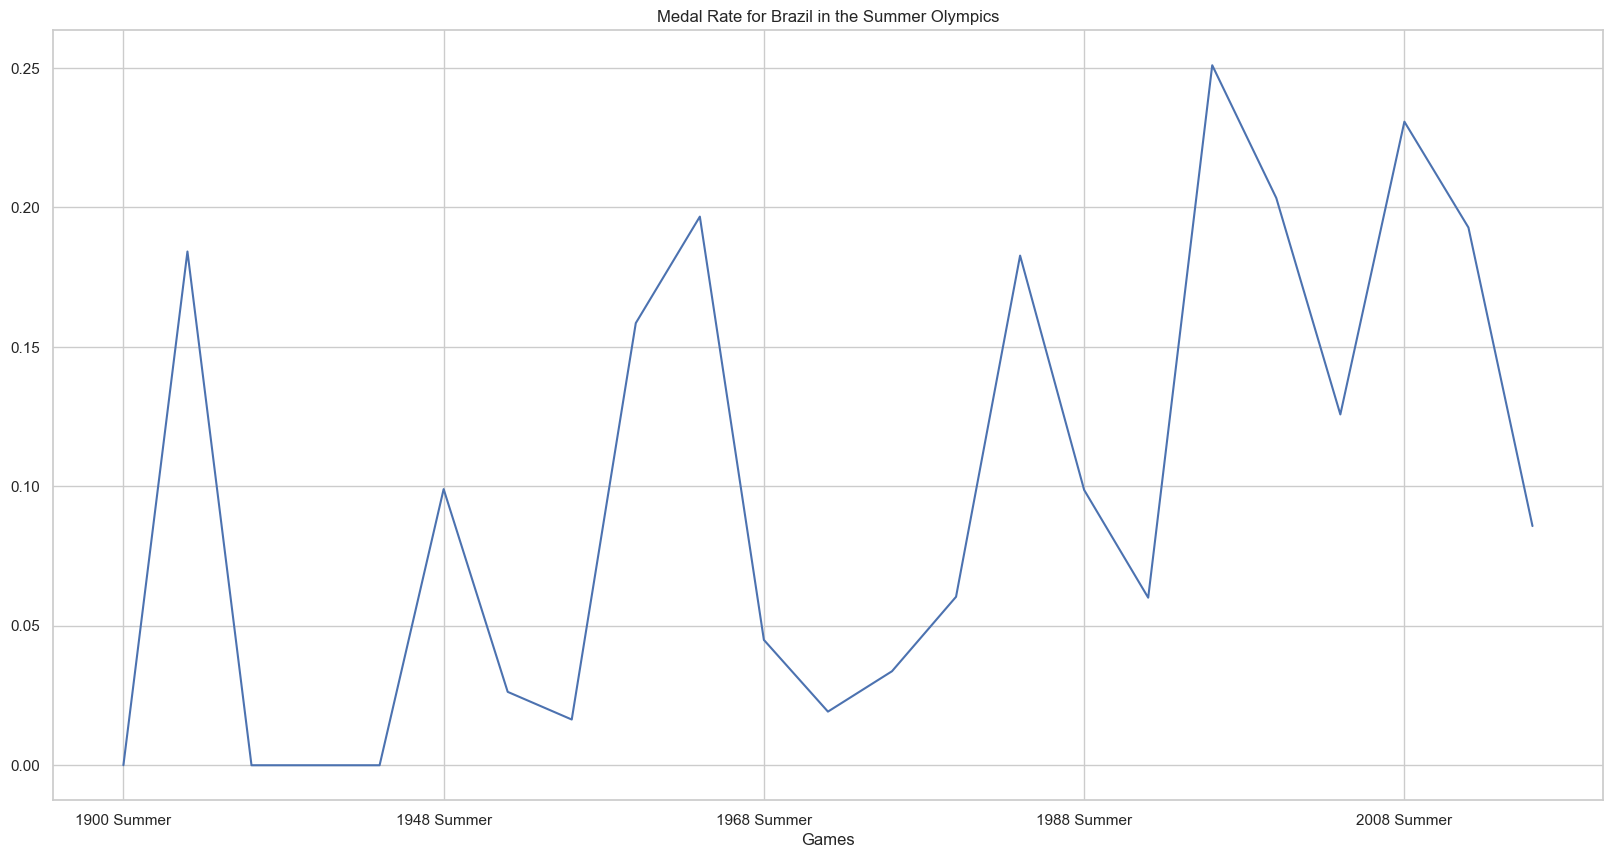

In [13]:
# Use a line chart to plot the medal_rate for the host country in the Summer Olympics.
games_df_host['medal_rate'].plot(kind='line', figsize=(20, 10), title='Medal Rate for Brazil in the Summer Olympics')

<Axes: xlabel='Games'>

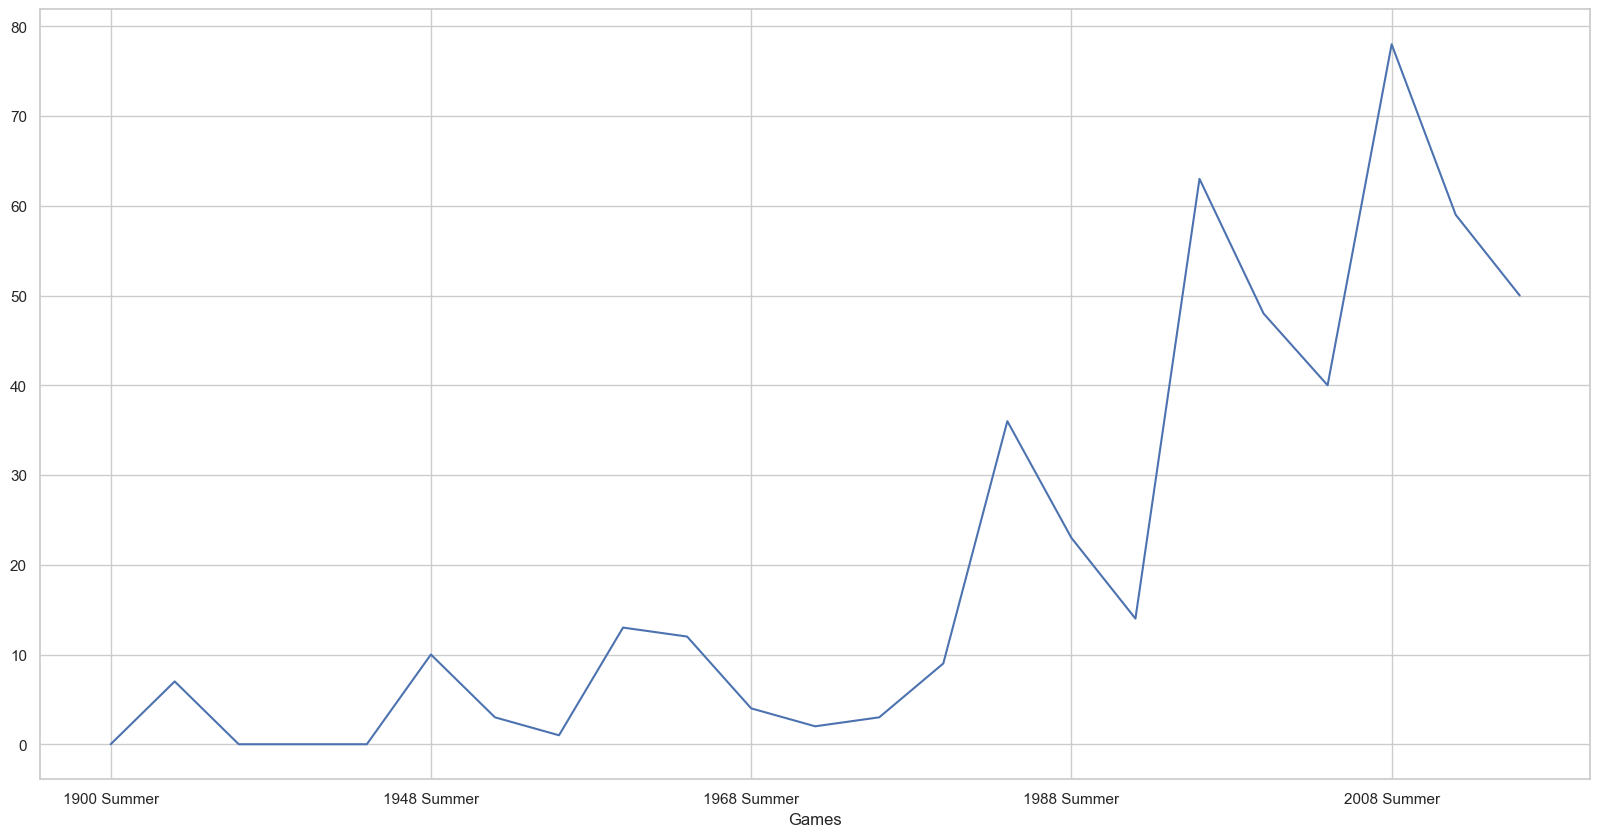

In [14]:
# Use a line chart to plot the medal count for the host country in the Summer Olympics.
games_df_host['total_medals'].plot(kind='line', figsize=(20, 10))

In [15]:
# Calculate the average medal count for your assigned team for the summer olympics
average_medal_count_host = games_df_host['total_medals'].mean()
print(average_medal_count_host)

# Calculate the average medal count for your assigned team  in the games where they won at least one medal
average_medal_count_host_won = games_df_host[games_df_host['total_medals'] > 0]['total_medals'].mean()
print(average_medal_count_host_won)

20.652173913043477
25.0


In [16]:
# Show the medal count for the host year Summer Games
games_df_host.loc[f'{host_year} Summer']

Medal                        50.000000
gold_medals                  36.000000
silver_medals                 8.000000
bronze_medals                 6.000000
total_medals                 50.000000
non_medal_participations    533.000000
total_participations        583.000000
medal_rate                    0.085763
gold_percentage              72.000000
silver_percentage            16.000000
bronze_percentage            12.000000
non_medal_percentage         91.423671
Name: 2016 Summer, dtype: float64

In [17]:
# Add z_scores column to the games_df_host dataframe
games_df_host['z_scores'] = zscore(games_df_host['total_medals'])
games_df_host

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage,z_scores
Games,,,,,,,,,,,,,
1900 Summer,0,0,0,0,0,3,3,0.000000,NaN,NaN,NaN,100.000000,-0.877798
1920 Summer,7,1,1,5,7,31,38,0.184211,14.285714,14.285714,71.428571,81.578947,-0.580271
1924 Summer,0,0,0,0,0,18,18,0.000000,NaN,NaN,NaN,100.000000,-0.877798
1932 Summer,0,0,0,0,0,67,67,0.000000,NaN,NaN,NaN,100.000000,-0.877798
1936 Summer,0,0,0,0,0,93,93,0.000000,NaN,NaN,NaN,100.000000,-0.877798
1948 Summer,10,0,0,10,10,91,101,0.099010,0.000000,0.000000,100.000000,90.099010,-0.452759
1952 Summer,3,1,0,2,3,111,114,0.026316,33.333333,0.000000,66.666667,97.368421,-0.750287
1956 Summer,1,1,0,0,1,60,61,0.016393,100.000000,0.000000,0.000000,98.360656,-0.835294
1960 Summer,13,0,0,13,13,69,82,0.158537,0.000000,0.000000,100.000000,84.146341,-0.325247


c:\Users\17049\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='total_medals', ylabel='Count'>

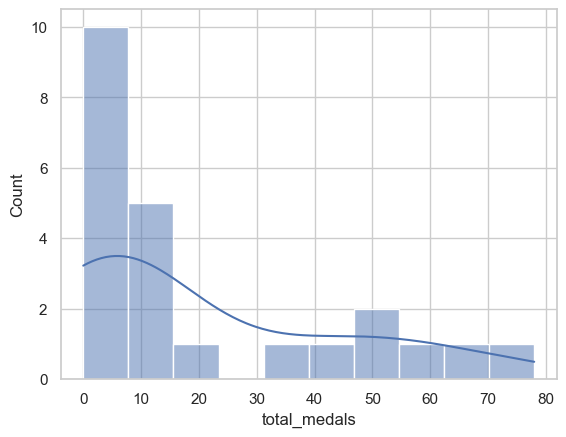

In [18]:
# Plot the distribution of the medal count for the host country in the Summer Olympics
sns.histplot(games_df_host['total_medals'], bins=10, kde=True)

In [19]:
mean_total_medals_host = games_df_host[games_df_host.index != f'{host_year} Summer']['total_medals'].mean()
print(mean_total_medals_host)

z_score_total_medals_host = zscore(games_df_host[games_df_host.index != f'{host_year} Summer']['total_medals'])
print(z_score_total_medals_host)

19.318181818181817
Games
1900 Summer   -0.833050
1920 Summer   -0.531192
1924 Summer   -0.833050
1932 Summer   -0.833050
1936 Summer   -0.833050
1948 Summer   -0.401824
1952 Summer   -0.703682
1956 Summer   -0.789927
1960 Summer   -0.272456
1964 Summer   -0.315579
1968 Summer   -0.660560
1972 Summer   -0.746805
1976 Summer   -0.703682
1980 Summer   -0.444947
1984 Summer    0.719363
1988 Summer    0.158770
1992 Summer   -0.229334
1996 Summer    1.883673
2000 Summer    1.236834
2004 Summer    0.891853
2008 Summer    2.530512
2012 Summer    1.711183
Name: total_medals, dtype: float64


In [20]:
# Using our games_df_rw dataframe, let's get the Summer Games data
summer_host_yr_rw = games_df_rw[games_df_rw['Games'] == f'{host_year} Summer']

# let's order this data by descending medal count
summer_host_yr_rw = summer_host_yr_rw.sort_values(by='Medal', ascending=False)

# let's only use the Games, NOC, and Medal columns
summer_host_yr_rw_short = summer_host_yr_rw[['Games', 'NOC', 'Medal']]
print('Medal Count for the Rest of the World:')
summer_host_yr_rw_short.head(15)

Medal Count for the Rest of the World:


,Games,NOC,Medal
2778,2016 Summer,USA,264
2652,2016 Summer,GER,159
2648,2016 Summer,GBR,145
2739,2016 Summer,RUS,115
2618,2016 Summer,CHN,113
2644,2016 Summer,FRA,96
2591,2016 Summer,AUS,82
2673,2016 Summer,ITA,72
2613,2016 Summer,CAN,69
2677,2016 Summer,JPN,64


In [21]:
# Let's calculate the average medal count for the rest of the world in the Summer Olympics
average_medal_count_rw_host_yr = summer_host_yr_rw['Medal'].mean()
average_medal_count_rw_host_yr

9.577669902912621